### Climatelearn testing 

In [1]:
# This jupyter notebook uses climatelearn tools 
# I use the same data from WeatherBench and compare the results with my implementation of ViT

In [1]:
import sys
print(sys.version)

3.10.8 (main, Nov 24 2022, 14:13:03) [GCC 11.2.0]


In [2]:
import torch as T
import torch.nn as nn
#from torchtext import data, datasets
#from torchtext.vocab import Vocab
import torch.optim as optim
import time
import copy
import torch
import torch.nn.functional as F
#from torchsummary import summary
import math

# Common imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import dask
import math
import datetime
from collections import OrderedDict


/storage/homefs/no21h426/.conda/envs/pyTT/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print("Cuda Avaliable :", torch.cuda.is_available())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Cuda Avaliable : True
cuda


In [4]:
from climate_learn.utils.data import load_dataset, view

DATADIR = '/storage/homefs/no21h426/WeatherBench-master/data/WeatherBench/5.625deg/'

In [5]:
# Load data module for forecasting task
from climate_learn.utils.datetime import Year, Days, Hours
from climate_learn.data import DataModule

In [8]:
data_module = DataModule(
    dataset = "ERA5",
    task = "forecasting",
    root_dir = DATADIR,
    in_vars = ["2m_temperature"],
    out_vars = ["geopotential"],
    train_start_year = Year(2015),
    val_start_year = Year(2016),
    test_start_year = Year(2017),
    end_year = Year(2018),
    pred_range = Days(3),
    subsample = Hours(1),
    batch_size = 128,
    num_workers = 1
)

Creating train dataset


  0%|          | 0/1 [00:00<?, ?it/s]


KeyError: 'geopotential'

In [9]:
from constants import (
    NAME_TO_VAR,
    DEFAULT_PRESSURE_LEVELS,
    CONSTANTS,
    SINGLE_LEVEL_VARS,
    PRESSURE_LEVEL_VARS,
)

In [10]:
constant_names = [
            name for name in ["temperature"] if NAME_TO_VAR[name] in CONSTANTS
        ]

In [11]:
non_const_names = [
    name for name in ["geopotential"] if name not in constant_names
]

In [16]:
non_const_names=['2m_temperature','temperature']

In [17]:
data_dict = {}
for name in non_const_names:
    if name in SINGLE_LEVEL_VARS:
        data_dict[name] = []
    elif name in PRESSURE_LEVEL_VARS:
       
        for level in DEFAULT_PRESSURE_LEVELS:
            data_dict[f"{name}_{level}"] = []
    else:
        raise NotImplementedError(f"{name} is not either in single-level or pressure-level dict")

In [18]:
data_dict

{'2m_temperature': [],
 'temperature_50': [],
 'temperature_250': [],
 'temperature_500': [],
 'temperature_600': [],
 'temperature_700': [],
 'temperature_850': [],
 'temperature_925': []}

In [19]:
for var in non_const_names:
    print(var)

2m_temperature
temperature


In [20]:
if var not in PRESSURE_LEVEL_VARS:
    print("test")

In [21]:
for var in non_const_names:
    year = Year(2015)
    dir_var = os.path.join(DATADIR, var)
    ps = glob.glob(os.path.join(dir_var, f"*{year}*.nc"))
    print(ps)
    xr_data = xr.open_mfdataset(ps, combine="by_coords")
    xr_data = xr_data[NAME_TO_VAR[var]]
    
    if len(xr_data.shape) == 3:  # 8760, 32, 64
            xr_data = xr_data.expand_dims(dim="level", axis=1)
            if var not in PRESSURE_LEVEL_VARS: 
                data_dict[var].append(xr_data)
            else:
                level = int(xr_data.level) # specify the level 
                data_dict[f"{var}_{level}"].append(xr_data)
               # data_dict = {i:j for i,j in data_dict.items() if j != []} # remove empty entries of pressure levels
    else:  # pressure level
        for level in DEFAULT_PRESSURE_LEVELS:
            print(level)
            xr_data_level = xr_data.sel(level=[level])
            data_dict[f"{var}_{level}"].append(xr_data_level)
            
#data_dict = {i:j for i,j in data_dict.items() if j != []}

['/storage/homefs/no21h426/WeatherBench-master/data/WeatherBench/5.625deg/2m_temperature/2m_temperature_2015_5.625deg.nc']
['/storage/homefs/no21h426/WeatherBench-master/data/WeatherBench/5.625deg/temperature/temperature_850hPa_2015_5.625deg.nc']


In [22]:
data_dict = {i:j for i,j in data_dict.items() if j != []}

In [23]:
data_dict

{'2m_temperature': [<xarray.DataArray 't2m' (time: 8760, level: 1, lat: 32, lon: 64)>
  dask.array<transpose, shape=(8760, 1, 32, 64), dtype=float32, chunksize=(8760, 1, 32, 64), chunktype=numpy.ndarray>
  Coordinates:
    * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
    * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
    * time     (time) datetime64[ns] 2015-01-01 ... 2015-12-31T23:00:00
  Dimensions without coordinates: level
  Attributes:
      units:      K
      long_name:  2 metre temperature],
 'temperature_850': [<xarray.DataArray 't' (time: 8760, level: 1, lat: 32, lon: 64)>
  dask.array<transpose, shape=(8760, 1, 32, 64), dtype=float32, chunksize=(8760, 1, 32, 64), chunktype=numpy.ndarray>
  Coordinates:
    * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
    * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
    * level    (level) int32 850
    * time     (time) dateti

In [24]:
data_dict = {k: xr.concat(data_dict[k], dim="time") for k in data_dict.keys()}

In [25]:
data_dict

{'2m_temperature': <xarray.DataArray 't2m' (time: 8760, level: 1, lat: 32, lon: 64)>
 dask.array<transpose, shape=(8760, 1, 32, 64), dtype=float32, chunksize=(8760, 1, 32, 64), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
   * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
   * time     (time) datetime64[ns] 2015-01-01 ... 2015-12-31T23:00:00
 Dimensions without coordinates: level
 Attributes:
     units:      K
     long_name:  2 metre temperature,
 'temperature_850': <xarray.DataArray 't' (time: 8760, level: 1, lat: 32, lon: 64)>
 dask.array<transpose, shape=(8760, 1, 32, 64), dtype=float32, chunksize=(8760, 1, 32, 64), chunktype=numpy.ndarray>
 Coordinates:
   * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
   * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
   * level    (level) int32 850
   * time     (time) datetime64[ns] 2015-01-0

In [26]:
# precipitation and solar radiation miss a few data points in the beginning
len_min = min([data_dict[k].shape[0] for k in data_dict.keys()])


In [27]:
data_dict = {k: data_dict[k][-len_min:] for k in data_dict.keys()}

In [28]:
data_dict

{'2m_temperature': <xarray.DataArray 't2m' (time: 8760, level: 1, lat: 32, lon: 64)>
 dask.array<transpose, shape=(8760, 1, 32, 64), dtype=float32, chunksize=(8760, 1, 32, 64), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
   * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
   * time     (time) datetime64[ns] 2015-01-01 ... 2015-12-31T23:00:00
 Dimensions without coordinates: level
 Attributes:
     units:      K
     long_name:  2 metre temperature,
 'temperature_850': <xarray.DataArray 't' (time: 8760, level: 1, lat: 32, lon: 64)>
 dask.array<transpose, shape=(8760, 1, 32, 64), dtype=float32, chunksize=(8760, 1, 32, 64), chunktype=numpy.ndarray>
 Coordinates:
   * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
   * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
   * level    (level) int32 850
   * time     (time) datetime64[ns] 2015-01-0

In [29]:
list(data_dict.keys())

['2m_temperature', 'temperature_850']

In [40]:
PRESSURE_LEVEL_VARS

['geopotential',
 'u_component_of_wind',
 'v_component_of_wind',
 'temperature',
 'relative_humidity',
 'specific_humidity',
 'vorticity',
 'potential_vorticity']

In [33]:
in_vars = ['2m_temperature']

In [42]:
out_vars = ["temperature"]

In [73]:
if any(x in PRESSURE_LEVEL_VARS for x in out_vars):
    #for pat in out_vars:
    #    print(pat + '_')
    #    print(pat.join'_')
    print([x for x in list(data_dict.keys()) if any(pat + '_' in x for pat in out_vars)])
else:
    [x for x in list(data_dict.keys()) if any(pat + '_' in x for pat in out_vars)]

['temperature_850']


In [68]:
print([x for x in list(data_dict.keys()) if any(pat in x for pat in out_vars)])

['2m_temperature', 'temperature_850']


In [52]:
if any(pat for pat in out_vars in PRESSURE_LEVEL_VARS):
    print(pat)
else:
    print("non level")

TypeError: 'bool' object is not iterable

In [35]:
[x for x in list(data_dict.keys()) if any(pat in x for pat in in_vars)]

['2m_temperature']

['2m_temperature', 'temperature_850']

In [30]:
inp_data = xr.concat([data_dict[k] for k in in_vars], dim="level")


In [32]:
out_data = xr.concat([data_dict[k] for k in out_vars], dim="level")
    

KeyError: 'geopotential'

In [33]:
data_dict

{'2m_temperature': <xarray.DataArray 't2m' (time: 8760, level: 1, lat: 32, lon: 64)>
 dask.array<transpose, shape=(8760, 1, 32, 64), dtype=float32, chunksize=(8760, 1, 32, 64), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
   * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
   * time     (time) datetime64[ns] 2015-01-01 ... 2015-12-31T23:00:00
 Dimensions without coordinates: level
 Attributes:
     units:      K
     long_name:  2 metre temperature,
 'geopotential_500': <xarray.DataArray 'z' (time: 8760, level: 1, lat: 32, lon: 64)>
 dask.array<transpose, shape=(8760, 1, 32, 64), dtype=float32, chunksize=(8760, 1, 32, 64), chunktype=numpy.ndarray>
 Coordinates:
   * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
   * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
   * level    (level) int32 500
   * time     (time) datetime64[ns] 2015-01-

In [23]:
inp_data = xr.concat([data_dict[k] for k in in_vars], dim="level")
#out_data = xr.concat([data_dict[k] for k in out_vars], dim="level")

KeyError: 'geopotential'

In [102]:
from tqdm import tqdm
from torch.utils.data import Dataset
from torchvision.transforms import transforms

In [105]:
from climate_learn.utils.datetime import Year, Hours

In [17]:
# Third party
import torch
from torch.utils.data import DataLoader
from pytorch_lightning import LightningDataModule

# TODO: include exceptions in docstrings
# TODO: document legal input/output variables for each dataset


def collate_fn(batch):
    r"""Collate function for DataLoaders.
    :param batch: A batch of data samples.
    :type batch: List[Tuple[torch.Tensor, torch.Tensor, List[str], List[str]]]
    :return: A tuple of `input`, `output`, `variables`, and `out_variables`.
    :rtype: Tuple[torch.Tensor, torch.Tensor, List[str], List[str]]
    """
    inp = torch.stack([batch[i][0] for i in range(len(batch))])
    out = torch.stack([batch[i][1] for i in range(len(batch))])
    variables = batch[0][2]
    out_variables = batch[0][3]
    return inp, out, variables, out_variables


class DataModule(LightningDataModule):
    """ClimateLearn's data module interface. Encapsulates dataset/task-specific
    data modules."""

    def __init__(
        self,
        dataset,
        task,
        root_dir,
        in_vars,
        out_vars,
        train_start_year,
        val_start_year,
        test_start_year,
        end_year=Year(2018),
        root_highres_dir=None,
        history: int = 1,
        window: int = 6,
        pred_range=Hours(6),
        subsample=Hours(1),
        batch_size=64,
        num_workers=0,
        pin_memory=False,
    ):
        r"""
        .. highlight:: python
        :param dataset: The name of the dataset to use. Currently supported
            options are: "ERA5".
        :type dataset: str
        :param task: The name of the task to use. Currently supported options
            are: "forecasting", "downscaling".
        :type task: str
        :param root_dir: The name of the local directory containing the
            specified dataset.
        :type root_dir: str
        :param in_vars: A list of input variables to use.
        :type in_vars: List[str]
        :param out_vars: A list of output variables to use.
        :type out_vars: List[str]
        :param train_start_year: The first year of the training set, inclusive.
        :type train_start_year: Year
        :param val_start_year: The first year of the validation set, inclusive.
            :python:`val_start_year` must be at least
            :python:`train_start_year+1` since the training set ends the year
            before :python:`val_start_year`. E.g., if
            :python:`train_start_year` is 1970, then
            :python:`val_start_year` must be 1971 or later.
        :type val_start_year: Year
        :param test_start_year: The first year of the testing set, inclusive.
            :python:`test_start_year` must be at least
            :python:`val_start_year+1` since the validation set ends the year
            before :python:`test_start_year`. E.g., if
            :python:`val_start_year` is 2015, then
            :python:`test_start_year` must be 2016 or later.
        :type test_start_year: Year
        :param end_year: The last year of the testing set, inclusive.
            Default is :python:`Year(2018)`.
        :type end_year: Year, optional
        :param root_highres_dir: The name of the high-res data directory, which
            is needed for downsclaing task. Default is `None`.
        :type root_highres_dir: str, optional
        """
        super().__init__()

        assert (
            end_year >= test_start_year
            and test_start_year > val_start_year
            and val_start_year > train_start_year
        )
        self.save_hyperparameters(logger=False)

        if dataset != "ERA5":
            raise NotImplementedError("Only support ERA5")
        if task == "downscaling" and root_highres_dir is None:
            raise NotImplementedError(
                "High-resolution data has to be provided for downscaling"
            )

        task_string = "Forecasting" if task == "forecasting" else "Downscaling"
        caller = eval(f"{dataset.upper()}{task_string}")

        train_years = range(train_start_year, val_start_year)
        self.train_dataset = caller(
            root_dir,
            root_highres_dir,
            in_vars,
            out_vars,
            history,
            window,
            pred_range.hours(),
            train_years,
            subsample.hours(),
            "train",
        )

        val_years = range(val_start_year, test_start_year)
        self.val_dataset = caller(
            root_dir,
            root_highres_dir,
            in_vars,
            out_vars,
            history,
            window,
            pred_range.hours(),
            val_years,
            subsample.hours(),
            "val",
        )
        self.val_dataset.set_normalize(
            self.train_dataset.inp_transform,
            self.train_dataset.out_transform,
            self.train_dataset.constant_transform,
        )

        test_years = range(test_start_year, end_year + 1)
        self.test_dataset = caller(
            root_dir,
            root_highres_dir,
            in_vars,
            out_vars,
            history,
            window,
            pred_range.hours(),
            test_years,
            subsample.hours(),
            "test",
        )
        self.test_dataset.set_normalize(
            self.train_dataset.inp_transform,
            self.train_dataset.out_transform,
            self.train_dataset.constant_transform,
        )

    def get_lat_lon(self):
        return self.train_dataset.lat, self.train_dataset.lon

    def get_out_transforms(self):
        return self.train_dataset.out_transform

    def get_climatology(self, split="val"):
        if split == "train":
            return self.train_dataset.get_climatology()
        elif split == "val":
            return self.val_dataset.get_climatology()
        elif split == "test":
            return self.test_dataset.get_climatology()
        else:
            raise NotImplementedError

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            shuffle=True,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            collate_fn=collate_fn,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            shuffle=False,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            collate_fn=collate_fn,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            shuffle=False,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            collate_fn=collate_fn,
        )

In [84]:
class ERA5(Dataset):
    def __init__(self, root_dir, root_highres_dir, variables, years, split="train"):
        super().__init__()
        self.root_dir = root_dir
        self.root_highres_dir = root_highres_dir
        self.variables = variables
        self.years = years
        self.split = split

        self.data_dict = self.load_from_nc(self.root_dir)
       
        
        if self.root_highres_dir is not None:
            self.data_highres_dict = self.load_from_nc(self.root_highres_dir)

        self.get_lat_lon()
      
       
    def load_from_nc(self, data_dir):
        #print(data_dir)
        #print(self.variables)
        #print(CONSTANTS)
        
        constant_names = [
            name for name in self.variables if NAME_TO_VAR[name] in CONSTANTS
        ]
        self.constants = {}
        if len(constant_names) > 0:
            ps = glob.glob(os.path.join(data_dir, "constants", "*.nc"))
            all_constants = xr.open_mfdataset(ps, combine="by_coords")
            for name in constant_names:
                self.constants[name] = all_constants[NAME_TO_VAR[name]]

        non_const_names = [
            name for name in self.variables if name not in constant_names
        ]
        data_dict = {}
        for name in non_const_names:
            if name in SINGLE_LEVEL_VARS:
                data_dict[name] = []
            elif name in PRESSURE_LEVEL_VARS:
                for level in DEFAULT_PRESSURE_LEVELS:
                    data_dict[f"{name}_{level}"] = []
            else:
                raise NotImplementedError(
                    f"{name} is not either in single-level or pressure-level dict"
                )

        for year in tqdm(self.years):
            for var in non_const_names:
                
                dir_var = os.path.join(data_dir, var)
                ps = glob.glob(os.path.join(dir_var, f"*{year}*.nc"))
                
                print(dir_var)
                print(ps)
                print(data_dict)
                
                xr_data = xr.open_mfdataset(ps, combine="by_coords")
                #print(xr_data)
                data_dict[var]
                xr_data = xr_data[NAME_TO_VAR[var]]
                # np_data = xr_data.to_numpy()
                if len(xr_data.shape) == 3:  # 8760, 32, 64
                    xr_data = xr_data.expand_dims(dim="level", axis=1)
                    data_dict[var].append(xr_data)
                else:  # pressure level
                    for level in DEFAULT_PRESSURE_LEVELS:
                        xr_data_level = xr_data.sel(level=[level])
                        data_dict[f"{var}_{level}"].append(xr_data_level)

        data_dict = {k: xr.concat(data_dict[k], dim="time") for k in data_dict.keys()}
        # precipitation and solar radiation miss a few data points in the beginning
        len_min = min([data_dict[k].shape[0] for k in data_dict.keys()])
        data_dict = {k: data_dict[k][-len_min:] for k in data_dict.keys()}

        return data_dict

    def get_lat_lon(self):
        # lat lon is stored in each of the nc files, just need to load one and extract
        dir_var = os.path.join(self.root_dir, self.variables[0])
        year = self.years[0]
        ps = glob.glob(os.path.join(dir_var, f"*{year}*.nc"))
        xr_data = xr.open_mfdataset(ps, combine="by_coords")
        self.lat = xr_data["lat"].to_numpy()
        self.lon = xr_data["lon"].to_numpy()

    def __getitem__(self, index):
        pass

    def __len__(self):
        pass



In [94]:
variables=["geopotential"]

In [95]:
VAR_TO_NAME['z']

'geopotential'

In [96]:
constant_names = [name for name in variables if NAME_TO_VAR[name] in CONSTANTS]
        

In [98]:
test = ERA5(DATADIR, None,["geopotential"], [Year(2015),Year(2018)])

  0%|          | 0/2 [00:00<?, ?it/s]


/storage/homefs/no21h426/WeatherBench-master/data/WeatherBench/5.625deg/geopotential
['/storage/homefs/no21h426/WeatherBench-master/data/WeatherBench/5.625deg/geopotential/geopotential_500hPa_2015_5.625deg.nc']
{'geopotential_50': [], 'geopotential_250': [], 'geopotential_500': [], 'geopotential_600': [], 'geopotential_700': [], 'geopotential_850': [], 'geopotential_925': []}


FileNotFoundError: [Errno 2] No such file or directory: b'/storage/homefs/no21h426/WeatherBench-master/data/WeatherBench/5.625deg/geopotential/geopotential_500hPa_2015_5.625deg.nc'

In [7]:
data_module.train_dataset.time

array(['2015-01-01T00:00:00.000000000', '2015-01-01T01:00:00.000000000',
       '2015-01-01T02:00:00.000000000', ...,
       '2015-12-28T21:00:00.000000000', '2015-12-28T22:00:00.000000000',
       '2015-12-28T23:00:00.000000000'], dtype='datetime64[ns]')

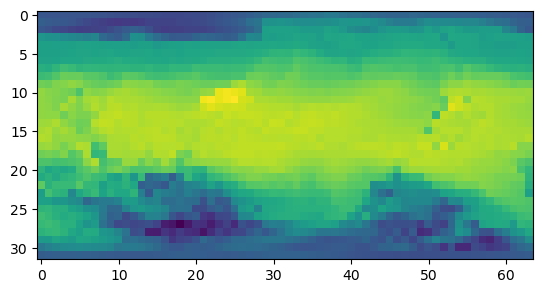

In [8]:
import matplotlib.pyplot as plt
plt.imshow(data_module.train_dataset.inp_data[0,0,:,:])

In [9]:
print(data_module.hparams.in_vars)

['2m_temperature']


In [10]:
from climate_learn.models import load_model

In [12]:
# for ViT
model_kwargs = {
     "img_size": [32, 64],
     "patch_size": 2,
     "drop_path": 0.1,
     "drop_rate": 0.1,
    "in_vars": data_module.hparams.in_vars,
     "learn_pos_emb": True,
     "out_vars": data_module.hparams.out_vars,
     "embed_dim": 128,
     "depth": 8,
     "decoder_depth": 0,
     "num_heads": 4,
     "mlp_ratio": 4,
 }

# for resnet
#model_kwargs = {
#    "in_channels": len(data_module.hparams.in_vars),
#    "out_channels": len(data_module.hparams.out_vars),
#    "n_blocks": 4
#}

optim_kwargs = {
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "warmup_epochs": 1,
    "max_epochs": 2,
}

model_module = load_model(name = "vit", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)
#model_module = load_model(name = "resnet", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)

In [16]:
model_module.net

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 128, kernel_size=(2, 2), stride=(2, 2))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=128, out_features=384, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=128, out_features=512, bias=True)
        (act): GELU(approximate=none)
        (drop1): Dropout(p=0.1, inplace=False)
        (fc2): Linear(in_features=512, out_features=128, bias=True)
        (drop2): Dropout(p=0.1, inplace=False)
      )
      (ls2): Identit

In [ ]:
from climate_learn.training import Trainer, WandbLogger
from rich.progress import track

trainer = Trainer(
    seed = 0,
    accelerator = "gpu",
    precision = 16,
    max_epochs = 5,
    logger = WandbLogger(project = "climate_tutorial", name = "forecast-vit")
)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find CCAI Tutorial.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

In [ ]:
# At the moment there are some issues when running some functions of climate_learn, need to check it out! 